
# Description

Score response texts for 'genericness' based on the underlying vocabulary distribution of the corpus.

Steps:
    
    1) Compute the underlying frequency distribution of corpus vocabulary
    
    2) Decide on a frequency threshold for identifying words that do not contribute non-generic content
    
    3) For each response text, compute the portion of generic words (#gen_words/#words)

**NOTE:** we use lower-case and lemmatisation as preprocessing

## Environment details:
   - gimli
   - readvisor38

In [1]:
%matplotlib inline
from typing import List, Dict, Tuple
from collections import Counter

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None) # don't truncate cell contents

from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
import matplotlib.pyplot as plt

import spacy

# from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = spacy.load('/srv/scratch2/kew/spacy_models/en_core_web_sm-2.3.1/en_core_web_sm/en_core_web_sm-2.3.1', disable=["tagger", "parser", "ner"])

/mnt/storage/clwork/users/kew/INSTALLS/anaconda3/envs/readvisor38/lib/python3.8/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('/srv/scratch6/kew/bart/hospo_respo/en/data/hotel/500k/trip_hotels.csv')
print(len(df))
# df = df[df['split'] == 'test']
# print(len(df))
print(df.columns)

500000
Index(['Unnamed: 0', 'domain', 'rating', 'review_author', 'response_author',
       'review_clean', 'response_clean', 'sentiment', 'db_internal_id',
       'establishment', 'trip_id', 'trip_url', 'country', 'split',
       'score:review_response_length_ratio', 'score:response_sentence_length',
       'score:genericness_semantic_avg', 'score:genericness_length_ratio',
       'score:review_response_wmd', 'rrgen_id'],
      dtype='object')


In [4]:
# df.to_pickle('/srv/scratch6/kew/bart/hospo_respo/en/data/hotel/500k/trip_hotels.pkl')

In [5]:
def normalise_texts(texts: List[str]) -> Tuple:
    """
    text preprocessing (tokenize, lemmatize, lowercase)
    """
    for doc in tqdm(nlp.pipe(texts, n_process=4, batch_size=2000)):
        yield list(tok.lemma_.lower() for tok in doc), doc.text

def build_distibution(corpus: List[str]) -> Counter:
    """
    builds simple frequency based vocabulary distribution
    """
    print(f'building distribution from {len(texts)} texts')
    freq_dist = Counter()
    for norm_text, _ in normalise_texts(corpus):
        freq_dist.update(norm_text)
    return freq_dist
        

# Note, to build the corpus distribution, only use training examples!
texts = df[df.split.isin(['train'])].response_clean.to_list()
response_dist = build_distibution(texts)
print(len(response_dist))
print(response_dist.most_common(500))
# list(response_dist.keys())[:1000]

building distribution from 450367 texts



211498
[('.', 1574661), ('to', 1522418), ('you', 1469094), ('the', 1303264), ('be', 1192749), ('your', 1034911), ('and', 938311), (',', 938184), ('we', 874526), ('for', 730252), ('a', 631274), ('our', 576241), ('that', 501236), ('thank', 472761), ('with', 425179), ('i', 412739), ('of', 408771), ('have', 401578), ('stay', 390784), ('in', 375922), ('us', 348817), ('review', 287101), ('time', 246148), ('again', 236641), ('hotel', 234018), ('!', 229142), ('on', 226906), ('guest', 218316), ('take', 204802), ('enjoy', 203261), ('dear', 197605), ('at', 197555), ('will', 194761), ('hope', 191352), ('back', 189478), ('it', 178605), ('welcome', 178355), ('so', 178066), ('look', 175116), ('kind', 174089), ('do', 163315), ('manager', 161901), ('feedback', 161706), ('much', 157719), ('forward', 156389), ('please', 156197), ('this', 154824), ('regard', 145719), ('very', 145419), ('not', 145407), ('experience', 144434), ('team', 141238), ('all', 132767), ('hear', 126741), ('see', 120575), ('future',

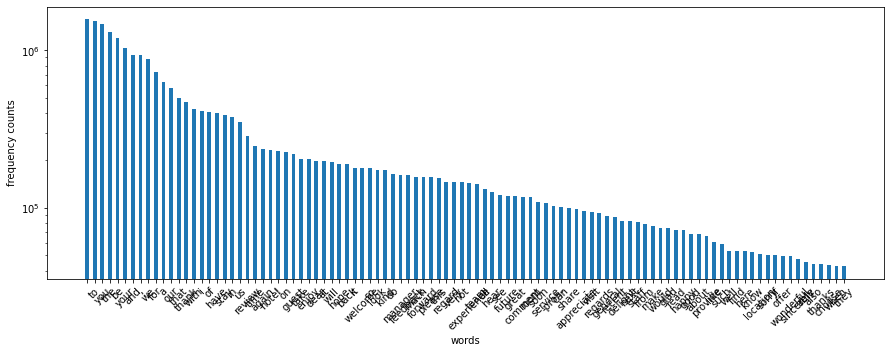

In [6]:
def visualise_dist(dist: Counter, n: int = 500):
    labels, values = zip(*{k: v for k, v in dist.most_common(n)}.items())
    indexes = np.arange(len(labels))
    
    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    width = 0.5
    ax.bar(indexes, values, width)
    ax.set_xlabel('words')
    plt.xticks(indexes, labels, rotation=45)

    ax.set_yscale('log')
    ax.set_ylabel('frequency counts')
#     plt.yticks(np.arange(80000, step=200))
    
    return

visualise_dist(response_dist, 100)

In [7]:
def check_threshold(dist: Counter, threshold_candidate: int) -> None:
    sorted_dist = {k: v for k, v in dist.most_common()}
    
    gen_word_count = sum(1 for v in sorted_dist.values() if v >= threshold_candidate)
    
    print(f'Threshold: {threshold_candidate}\tGeneric words: {(gen_word_count/(len(dist)-gen_word_count))*100:.5f}%')
    
    
for t in [10000, 8000, 6000, 5000, 4000, 2000, 1000, 500, 100]:
    check_threshold(response_dist, t)

Threshold: 10000	Generic words: 0.15106%
Threshold: 8000	Generic words: 0.17905%
Threshold: 6000	Generic words: 0.21892%
Threshold: 5000	Generic words: 0.25693%
Threshold: 4000	Generic words: 0.30352%
Threshold: 2000	Generic words: 0.48604%
Threshold: 1000	Generic words: 0.75603%
Threshold: 500	Generic words: 1.17246%
Threshold: 100	Generic words: 2.93627%


In [8]:
def score_text_on_distribution(text_tokens: List[str], dist: Counter, freq_threshold: int = 1000) -> float:
    """
    Computes the ratio #gen_words/#words
    
    A higher frequency threshold results in a lower 'genericness' score as fewer words will be identified as generic
    """
    freq_toks = sum((1 for tok in text_tokens if dist[tok] > freq_threshold))
    return freq_toks / len(text_tokens)

scores = []
for norm_text, _ in normalise_texts(df['response_clean'].to_list()):
    score = score_text_on_distribution(norm_text, response_dist, 5000)
    scores.append(score)

print(len(scores))

df['score:response_freq_distro_ratio'] = scores
df['score:response_freq_distro_ratio'].describe()


500000


count    500000.000000
mean          0.889702
std           0.055622
min           0.230769
25%           0.857143
50%           0.895238
75%           0.927536
max           1.000000
Name: score:response_freq_distro_ratio, dtype: float64

In [9]:
df.sort_values(by=['score:response_freq_distro_ratio'], ascending=True)

,Unnamed: 0,domain,rating,review_author,response_author,review_clean,response_clean,sentiment,db_internal_id,establishment,trip_id,trip_url,country,split,score:review_response_length_ratio,score:response_sentence_length,score:genericness_semantic_avg,score:genericness_length_ratio,score:review_response_wmd,rrgen_id,score:response_freq_distro_ratio
416010,1705201,Hotel,4,57javids,RoryGM,"Great night stay ---SEP--- Impressed with the cleanliness, style, and comfort. Cherry on top if had hot / cooked breakfast. A complimentary bottle of irn in room along with a nice welcoming note. Was a cold night mitigated by efficient heating in the room.",Alright javids Canny whack an irn bru pal eh? All good Rory,3 -1 4,730218,ibis Styles Glasgow Centre West,15037951,https://www.tripadvisor.co.uk/Hotel_Review-g186534-or55-d15037951-Reviews-Ibis_Styles_Glasgow_Centre_West-Glasgow_Scotland.html,UK,train,2.000000,2,0.536215,0.0,4.413717,1705201,0.230769
51837,15495,Hotel,5,c0linrh0me,Rory M,"Cool Place ---SEP--- We were very impressed with this hotel. It has a cool, clean atmosphere. The location is central and close to the station. It was good value and friendly with breakfast included. We liked the Glasgow music theme throughout.",Agreed. Rory,3 -1 3,1105828,ibis Styles Glasgow Centre West,15037951,https://www.tripadvisor.co.uk/Hotel_Review-g186534-or420-d15037951-Reviews-Ibis_Styles_Glasgow_Centre_West-Glasgow_Scotland.html,UK,train,2.500000,2,0.660929,0.0,5.533234,15495,0.333333
98596,288244,Hotel,1,Jedd94,MagnoliaCourt,"(SCAMMERS) DO NOT STAY HERE, YOU WILL BE RIPPED OFF ---SEP--- Do not give your Credit card details !! The people of this motel are scammers. They will charge your credit card without your concent & for their own made up reasons. DO NOT STAY HERE, YOU WILL BE RIPPED OFF!!",?????? Case of mistaken identity?? This reviewer did not stay here.,2 -2 -2,87309,Magnolia Court Motel,1652091,https://www.tripadvisor.co.nz/Hotel_Review-g1159325-or0-d1652091-Reviews-Magnolia_Court_Motel-Opotiki_Bay_of_Plenty_Region_North_Island.html,NZ,train,2.000000,2,0.323597,0.0,4.718174,288244,0.368421
192887,3027565,Hotel,4,1933magna,Cristina L,"Vert good hotel at reasonable price. ---SEP--- Overall a very nice hotel at a good price. Room was clean and comfortable, but starting to show some aging. Free easy parking and rooms were quiet and well insulated from local traffic noise. Would stay there again.","Thank you for taking the time from your busy schedule to write a review! We hope you will come back and stay with us again soon. Please contact me personally to arrange your next visit so I can ensure your next stay is nothing less than exceptional. Warm Regards, Maria Cristina Londono | Guest Services Manager Maria.londono@ambassadorhotel.com Phone: 613-548-3605 | 1-800-267-7880 ______________________________________________________________________________",3 -1 3,99445,Ambassador Hotel & Conference Centre,182868,https://www.tripadvisor.ca/Hotel_Review-g154992-or840-d182868-Reviews-Ambassador_Hotel_Conference_Centre-Kingston_Ontario.html,CA,valid,1.250000,4,0.713699,0.0,5.037137,3027565,0.383117
82169,1603141,Hotel,1,Craig A,Karen B,"Noisy uncomfortble awful stay ---SEP--- Rooms look nothing like the pictures online,no privacy what so ever,worst bed we have ever slept in,all parking directlly in front of rooms,old rooms overdue for a re furb,servced our room at 3 pm we had to wait outside in the heat with our 2yr old,room was stuffy and musty,no lighting in bbq area,spoke to management and told they could not help,i would not recommend staying here ,the park bench across the road would be more comfortable and a far better option",************This is a duplicate review of the review directly beneath it under a different user name.************* We look forward to reading further reviews from this account.,2 -2 -2,360533,The Beach Motel Hervey Bay,4346737,https://www.tripadvisor.com.au/Hotel_Review-g1214321-or160-d4346737-Reviews-The_Beach_Motel_Herv

In [10]:
df.head()

,Unnamed: 0,domain,rating,review_author,response_author,review_clean,response_clean,sentiment,db_internal_id,establishment,trip_id,trip_url,country,split,score:review_response_length_ratio,score:response_sentence_length,score:genericness_semantic_avg,score:genericness_length_ratio,score:review_response_wmd,rrgen_id,score:response_freq_distro_ratio
0,2329375,Hotel,5,Lucy J,RCCharlotte,Fantastic! ---SEP--- We were treated like royalty during our stay. We actually live in Charlotte but stayed here during a two day event uptown in Charlotte. Staff incredible detail oriented and friendly. Superior service everywhere we looked! Prices are high but you get what you okay for. It was truly a pleasure to stay at such a high quality hotel. Would recommend to everyone!,"Dear Lucy J, Thank you for sharing your experience with the Trip Advisor community. I am thrilled you enjoyed the amenities and services during your visit to Uptown. Again, thank you for taking the time to write such a lovely review about the hotel. We look forward to welcoming you back in the near future. Sincerely, David Rothwell General Manager",3 -1 3,126080,"The Ritz-Carlton, Charlotte",1510383,https://www.tripadvisor.com/Hotel_Review-g49022-or530-d1510383-Reviews-The_Ritz_Carlton_Charlotte-Charlotte_North_Carolina.html,US,train,1.600000,5,0.879500,0.400000,4.637085,2329375,0.940299
1,2770320,Hotel,4,OYEWOLE O,CPHIEXManagementTeam,"Convenient ---SEP--- The hotel is custom-made for a traveller in transit or anyone who wants to avoid the hassle of catching a flight at Heathrow's Terminal 4 in good time. A tunnel links the hotel to the terminal. From your room, you simply check out and drag your luggage through the tunnel to the departure hall. No hassles. The hotel is clean and the staff are quite friendly and helpful. Next door is the Holiday Inn which shares common elevator with Crowne Plaza. You can have the best of two worlds by also sampling the offerings in the hotel next door. Nice place!","Dear OYEWOLE O, Thank you for your kind feedback and for choosing The New Crowne Plaza at London Heathrow T4. We are delighted to understand that you found our hotel to be convenient for your journey through London Heathrow Airport. We will share your most positive comments with our dedicated team. Thank you once again and we look forward to welcoming you in the future. Warm Regards, Andrew Brown. General Manager Crowne Plaza London Heathrow T4.",2 -2 2,147558,Crowne Plaza London Heathrow T4,14151392,https://www.tripadvisor.co.uk/Hotel_Review-g528813-or495-d14151392-Reviews-Crowne_Plaza_London_Heathrow_T4-Hounslow_Greater_London_England.html,UK,train,1.333333,6,0.829168,0.166667,4.310637,2770320,0.880952
2,1652943,Hotel,4,Jeff M,fairholminnkeeper,"Authentic house, authentic people ---SEP--- Stayed for two nights, my wife and I - her sister and husband who are from Vancouver. all of us approx 60. He wanted an authentic historical setting, plus king bed, etc. We have done a lot of B & B's in Maine over the years so less of an issue for us. I called about a month ahead and they only had one King Bedroom left in the main house, but they had just redone their Coachhouse on the same property so inlaws in main house, my wife and I in Coach house. King Room was the real thing, king bed, propane fireplace, spacious. only modern was bathroom which was redone but with fixtures with a traditional look. very nice. Our 'room' was a one-bedroom apt, very modern looking, open kitchen (fully equiped) king bed, 2 TVs. could have stayed a month and been quite comfortable. Breakfast was two choices which varied each morning (i.e. eggs benedict), plus a yoghurt with fruit and granola, and baked goods. Very pleasant staff who went out of their way to share local knowledge. SIMPLY NICE PEOPLE. Location was in residential area, about three blocks from the waterfront and two blocks from one of the top hundred places to eat in Canada. Staff wisely advised we reserve ahead! It was high season, At first 

In [11]:
# save newly computed scores
df['score:response_freq_distro_ratio'].to_pickle('/srv/scratch6/kew/bart/hospo_respo/en/data/hotel/500k/trip_hotels.zipf_dist_scores.pkl')


In [13]:
# new_col = pd.read_pickle('/srv/scratch6/kew/bart/hospo_respo/en/data/hotel/500k/trip_hotels.zipf_dist_scores.pkl')
# new_col == df['score:response_freq_distro_ratio']